In [2]:
import pandas as pd

# 讀取 CSV 檔案
file_path = "C:/Users/USER/Downloads/NLP-Courses/NLP220/Assignments/processed_books_data.csv"
df = pd.read_csv(file_path)

# 檢視前五筆資料
print(df.head())


           Id                           Title  Price         User_id  \
0  1882931173  Its Only Art If Its Well Hung!    NaN   AVCGYZL8FQQTD   
1  0826414346        Dr. Seuss: American Icon    NaN  A30TK6U7DNS82R   
2  0826414346        Dr. Seuss: American Icon    NaN  A3UH4UZ4RSVO82   
3  0826414346        Dr. Seuss: American Icon    NaN  A2MVUWT453QH61   
4  0826414346        Dr. Seuss: American Icon    NaN  A22X4XUPKF66MR   

                          profileName review/helpfulness  review/score  \
0               Jim of Oz "jim-of-oz"                7/7           4.0   
1                       Kevin Killian              10/10           5.0   
2                        John Granger              10/11           5.0   
3  Roy E. Perry "amateur philosopher"                7/7           4.0   
4     D. H. Richards "ninthwavestore"                3/3           4.0   

   review/time                                   review/summary  \
0    940636800           Nice collection of Julie Strai

In [3]:
# 篩選只包含 1, 2, 4, 5 星評分的資料
df_filtered = df[df['review/score'].isin([1, 2, 4, 5])]

# 新增 'label' 欄位，根據評分來分類
df_filtered['label'] = df_filtered['review/score'].apply(lambda x: 1 if x >= 4 else 0)

# 檢視結果
print(df_filtered[['review/score', 'label']].head())


   review/score  label
0           4.0      1
1           5.0      1
2           5.0      1
3           4.0      1
4           4.0      1


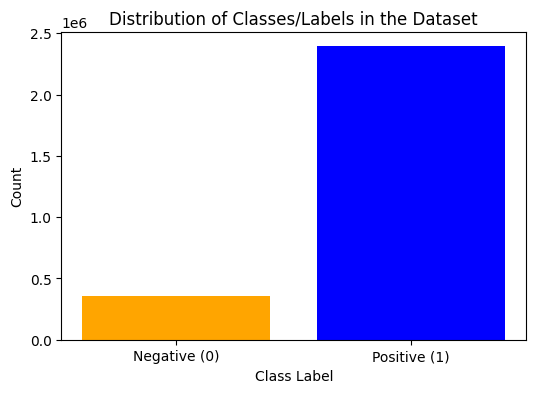

In [4]:
import matplotlib.pyplot as plt

# 繪製類別/標籤的分佈情況
label_counts = df_filtered['label'].value_counts()

plt.figure(figsize=(6,4))
plt.bar(label_counts.index, label_counts.values, color=['blue', 'orange'])
plt.xticks([0, 1], ['Negative (0)', 'Positive (1)'])
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.title('Distribution of Classes/Labels in the Dataset')

# 顯示結果
plt.show()

In [5]:
# 檢查正向和負向評論的分布情況
print(df_filtered['label'].value_counts())

label
1    2392959
0     352746
Name: count, dtype: int64


In [6]:
import sklearn
from sklearn.model_selection import train_test_split

# 分割資料集，85% 用於訓練，15% 用於測試
train_data, test_data = train_test_split(df_filtered, test_size=0.15, random_state=42, stratify=df_filtered['label'])
# 檢查分割後的資料大小
print("訓練集大小:", train_data.shape)

print("測試集大小:", test_data.shape)


訓練集大小: (2333849, 11)
測試集大小: (411856, 11)


In [14]:
from sklearn.feature_extraction.text import CountVectorizer
# 移除 'review/text' 欄位中為 NaN 的列
train_data = train_data.dropna(subset=['review/text'])
test_data = test_data.dropna(subset=['review/text'])
vectorizer_count = CountVectorizer(stop_words='english', max_features=3000)
X_train_count = vectorizer_count.fit_transform(train_data['review/text'])
X_test_count = vectorizer_count.transform(test_data['review/text'])


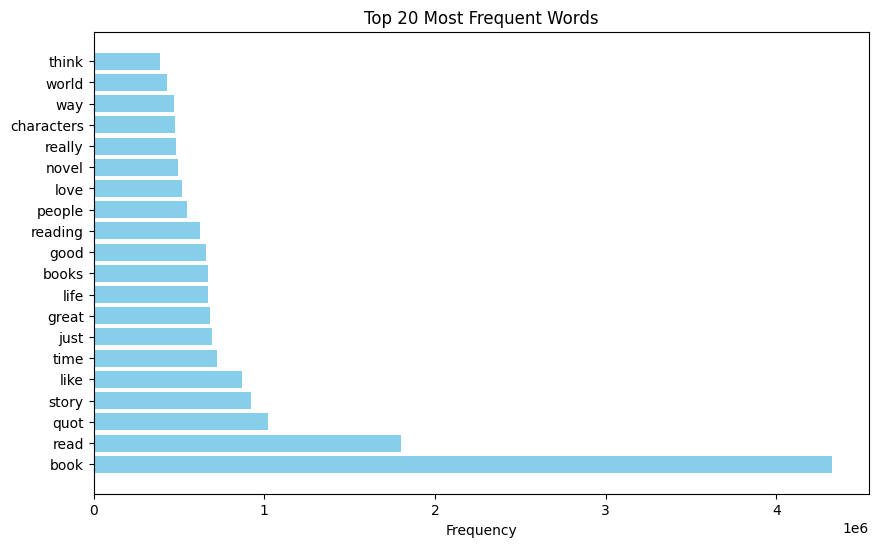

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# 獲取詞彙名稱
feature_names = vectorizer_count.get_feature_names_out()

# 獲取每個詞的出現次數
word_counts = np.asarray(X_train_count.sum(axis=0)).flatten()

# 將詞和其頻次配對
word_freq = list(zip(feature_names, word_counts))

# 按頻次排序，取前20個最常見詞
word_freq_sorted = sorted(word_freq, key=lambda x: x[1], reverse=True)[:20]

# 分開詞和頻次
words, counts = zip(*word_freq_sorted)

# 視覺化最常見的詞及其頻次
plt.figure(figsize=(10,6))
plt.barh(words, counts, color='skyblue')
plt.xlabel('Frequency')
plt.title('Top 20 Most Frequent Words')
plt.gca()#.invert_yaxis()  # 反轉 y 軸，讓最高頻詞在頂部
plt.show()


In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer_tfidf = TfidfVectorizer(stop_words='english', max_features=3000)
X_train_tfidf = vectorizer_tfidf.fit_transform(train_data['review/text'])
X_test_tfidf = vectorizer_tfidf.transform(test_data['review/text'])


In [9]:
train_data['combined_text'] = train_data['review/summary'] + " " + train_data['review/text']
test_data['combined_text'] = test_data['review/summary'] + " " + test_data['review/text']
# 填補 NaN 值
train_data['combined_text'] = train_data['combined_text'].fillna('')
test_data['combined_text'] = test_data['combined_text'].fillna('')

# 使用 TfidfVectorizer 處理
vectorizer_combined = TfidfVectorizer(stop_words='english', max_features=100)
X_train_combined = vectorizer_combined.fit_transform(train_data['combined_text'])
X_test_combined = vectorizer_combined.transform(test_data['combined_text'])


In [10]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import time

# 建立 Naive Bayes 模型
nb_model_count = MultinomialNB()
nb_model_tfidf = MultinomialNB()
nb_model_combined = MultinomialNB()

# 訓練與預測
def train_and_evaluate(model, X_train, X_test, y_train, y_test):
    # 訓練模型
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time
    
    # 預測
    start_time = time.time()
    y_pred = model.predict(X_test)
    inference_time = time.time() - start_time

    # 計算評估指標
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    cm = confusion_matrix(y_test, y_pred)
    
    return accuracy, f1, cm, train_time, inference_time

# 標籤資料
y_train = train_data['label']
y_test = test_data['label']

# 訓練與評估 Count Vectorizer 特徵
acc_count, f1_count, cm_count, train_time_count, inference_time_count = train_and_evaluate(nb_model_count, X_train_count, X_test_count, y_train, y_test)

# 訓練與評估 Tfidf 特徵
acc_tfidf, f1_tfidf, cm_tfidf, train_time_tfidf, inference_time_tfidf = train_and_evaluate(nb_model_tfidf, X_train_tfidf, X_test_tfidf, y_train, y_test)

# 訓練與評估 Combined 特徵
acc_combined, f1_combined, cm_combined, train_time_combined, inference_time_combined = train_and_evaluate(nb_model_combined, X_train_combined, X_test_combined, y_train, y_test)

# 結果輸出
print("Count Vectorizer - Accuracy: {:.4f}, F1: {:.4f}, Training time: {:.4f}s, Inference time: {:.4f}s".format(acc_count, f1_count, train_time_count, inference_time_count))
print("Tfidf Vectorizer - Accuracy: {:.4f}, F1: {:.4f}, Training time: {:.4f}s, Inference time: {:.4f}s".format(acc_tfidf, f1_tfidf, train_time_tfidf, inference_time_tfidf))
print("Combined Features - Accuracy: {:.4f}, F1: {:.4f}, Training time: {:.4f}s, Inference time: {:.4f}s".format(acc_combined, f1_combined, train_time_combined, inference_time_combined))

print("Confusion Matrix for Count Vectorizer:\n", cm_count)
print("Confusion Matrix for Tfidf Vectorizer:\n", cm_tfidf)
print("Confusion Matrix for Combined Features:\n", cm_combined)


Count Vectorizer - Accuracy: 0.8601, F1: 0.6067, Training time: 0.4128s, Inference time: 0.0340s
Tfidf Vectorizer - Accuracy: 0.8715, F1: 0.4657, Training time: 0.4539s, Inference time: 0.0290s
Combined Features - Accuracy: 0.8715, F1: 0.4657, Training time: 0.4423s, Inference time: 0.0280s
Confusion Matrix for Count Vectorizer:
 [[ 11825  41087]
 [ 16550 342394]]
Confusion Matrix for Tfidf Vectorizer:
 [[     0  52912]
 [     0 358944]]
Confusion Matrix for Combined Features:
 [[     0  52912]
 [     0 358944]]


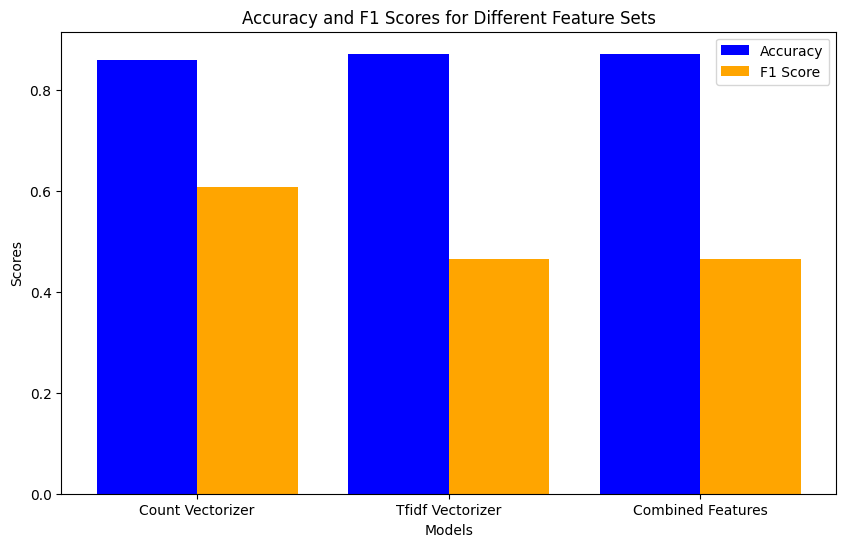

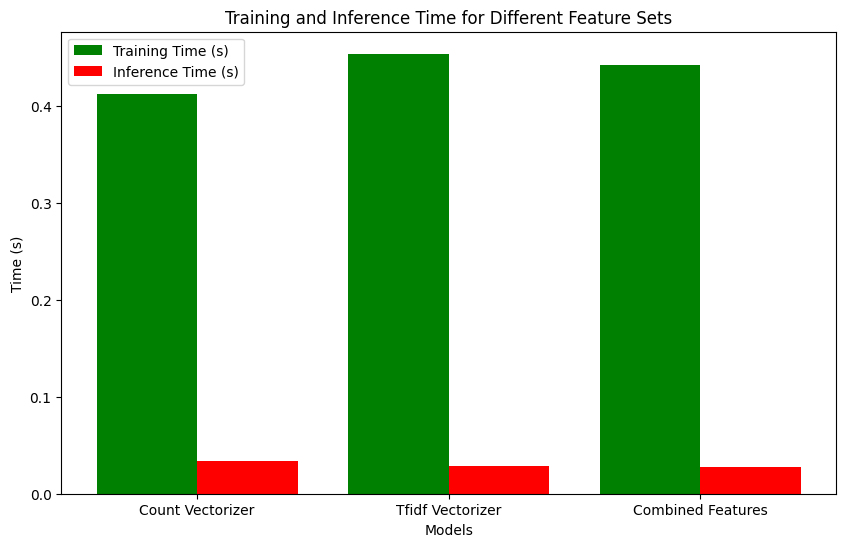

In [11]:
import numpy as np

# 準備數據進行可視化
models = ['Count Vectorizer', 'Tfidf Vectorizer', 'Combined Features']
accuracies = [acc_count, acc_tfidf, acc_combined]
f1_scores = [f1_count, f1_tfidf, f1_combined]
train_times = [train_time_count, train_time_tfidf, train_time_combined]
inference_times = [inference_time_count, inference_time_tfidf, inference_time_combined]

# 繪製準確率與 F1 分數的柱狀圖
plt.figure(figsize=(10,6))
x = np.arange(len(models))

# 準確率
plt.bar(x - 0.2, accuracies, 0.4, label='Accuracy', color='blue')
# F1 分數
plt.bar(x + 0.2, f1_scores, 0.4, label='F1 Score', color='orange')

plt.xticks(x, models)
plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Accuracy and F1 Scores for Different Feature Sets')
plt.legend()

# 顯示結果
plt.show()

# 繪製訓練與推理時間的柱狀圖
plt.figure(figsize=(10,6))

# 訓練時間
plt.bar(x - 0.2, train_times, 0.4, label='Training Time (s)', color='green')
# 推理時間
plt.bar(x + 0.2, inference_times, 0.4, label='Inference Time (s)', color='red')

plt.xticks(x, models)
plt.xlabel('Models')
plt.ylabel('Time (s)')
plt.title('Training and Inference Time for Different Feature Sets')
plt.legend()

# 顯示結果
plt.show()


In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import time

# 建立 Decision Tree 模型
dt_model_count = DecisionTreeClassifier(max_depth=10,min_samples_leaf=5)
dt_model_tfidf = DecisionTreeClassifier(max_depth=10,min_samples_leaf=5)
dt_model_combined = DecisionTreeClassifier(max_depth=10,min_samples_leaf=5)

# 訓練與預測
def train_and_evaluate(model, X_train, X_test, y_train, y_test):
    # 訓練模型
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time
    
    # 預測
    start_time = time.time()
    y_pred = model.predict(X_test)
    inference_time = time.time() - start_time

    # 計算評估指標
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    cm = confusion_matrix(y_test, y_pred)
    
    return accuracy, f1, cm, train_time, inference_time

# 標籤資料
y_train = train_data['label']
y_test = test_data['label']

# 訓練與評估 Count Vectorizer 特徵
acc_count, f1_count, cm_count, train_time_count, inference_time_count = train_and_evaluate(dt_model_count, X_train_count, X_test_count, y_train, y_test)

# 訓練與評估 Tfidf 特徵
acc_tfidf, f1_tfidf, cm_tfidf, train_time_tfidf, inference_time_tfidf = train_and_evaluate(dt_model_tfidf, X_train_tfidf, X_test_tfidf, y_train, y_test)

# 訓練與評估 Combined 特徵
acc_combined, f1_combined, cm_combined, train_time_combined, inference_time_combined = train_and_evaluate(dt_model_combined, X_train_combined, X_test_combined, y_train, y_test)

# 結果輸出
print("Count Vectorizer - Accuracy: {:.4f}, F1: {:.4f}, Training time: {:.4f}s, Inference time: {:.4f}s".format(acc_count, f1_count, train_time_count, inference_time_count))
print("Tfidf Vectorizer - Accuracy: {:.4f}, F1: {:.4f}, Training time: {:.4f}s, Inference time: {:.4f}s".format(acc_tfidf, f1_tfidf, train_time_tfidf, inference_time_tfidf))
print("Combined Features - Accuracy: {:.4f}, F1: {:.4f}, Training time: {:.4f}s, Inference time: {:.4f}s".format(acc_combined, f1_combined, train_time_combined, inference_time_combined))

print("Confusion Matrix for Count Vectorizer:\n", cm_count)
print("Confusion Matrix for Tfidf Vectorizer:\n", cm_tfidf)
print("Confusion Matrix for Combined Features:\n", cm_combined)


Count Vectorizer - Accuracy: 0.8721, F1: 0.4803, Training time: 62.8918s, Inference time: 0.0551s
Tfidf Vectorizer - Accuracy: 0.8730, F1: 0.4971, Training time: 86.8293s, Inference time: 0.0935s
Combined Features - Accuracy: 0.8737, F1: 0.5063, Training time: 89.9217s, Inference time: 0.0855s
Confusion Matrix for Count Vectorizer:
 [[   790  52122]
 [   553 358391]]
Confusion Matrix for Tfidf Vectorizer:
 [[  1738  51174]
 [  1141 357803]]
Confusion Matrix for Combined Features:
 [[  2272  50640]
 [  1368 357576]]


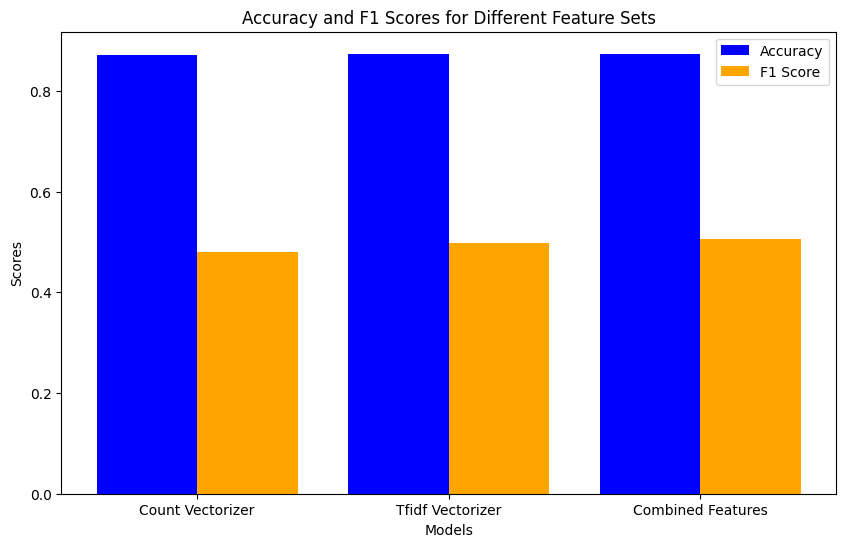

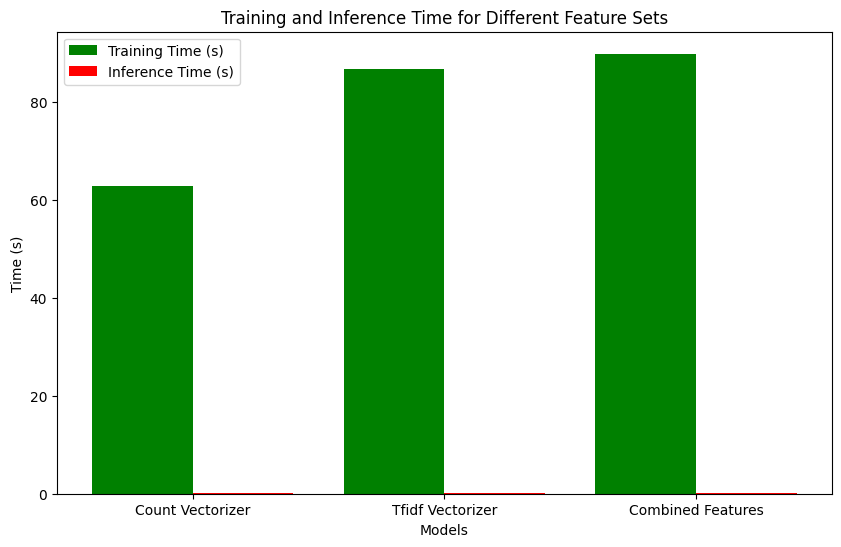

In [13]:
# Importing necessary libraries for plotting
import matplotlib.pyplot as plt

# Since we already have the defined variables, let's proceed with plotting

# Prepare data for visualization
models = ['Count Vectorizer', 'Tfidf Vectorizer', 'Combined Features']
accuracies = [acc_count, acc_tfidf, acc_combined]
f1_scores = [f1_count, f1_tfidf, f1_combined]
train_times = [train_time_count, train_time_tfidf, train_time_combined]
inference_times = [inference_time_count, inference_time_tfidf, inference_time_combined]

# Plot accuracy and F1 scores
plt.figure(figsize=(10,6))
x = np.arange(len(models))

# Accuracy
plt.bar(x - 0.2, accuracies, 0.4, label='Accuracy', color='blue')
# F1 score
plt.bar(x + 0.2, f1_scores, 0.4, label='F1 Score', color='orange')

plt.xticks(x, models)
plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Accuracy and F1 Scores for Different Feature Sets')
plt.legend()

# Display the plot
plt.show()

# Plot training and inference time
plt.figure(figsize=(10,6))

# Training time
plt.bar(x - 0.2, train_times, 0.4, label='Training Time (s)', color='green')
# Inference time
plt.bar(x + 0.2, inference_times, 0.4, label='Inference Time (s)', color='red')

plt.xticks(x, models)
plt.xlabel('Models')
plt.ylabel('Time (s)')
plt.title('Training and Inference Time for Different Feature Sets')
plt.legend()

# Display the plot
plt.show()


In [19]:
from joblib import parallel_backend
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import time

# 建立 LinearSVC 模型
svc_model_count = LinearSVC()
svc_model_tfidf = LinearSVC()
svc_model_combined = LinearSVC()

# 訓練與預測函數
def train_and_evaluate(model, X_train, X_test, y_train, y_test):
    # 訓練模型
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time
    
    # 預測
    start_time = time.time()
    y_pred = model.predict(X_test)
    inference_time = time.time() - start_time

    # 計算評估指標
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    cm = confusion_matrix(y_test, y_pred)
    
    return accuracy, f1, cm, train_time, inference_time

# 標籤資料
y_train = train_data['label']
y_test = test_data['label']

# 使用 joblib 進行多核並行運算
with parallel_backend('threading', n_jobs=-1):  # 使用所有可用的 CPU 核心
    # 訓練與評估 Count Vectorizer 特徵
    acc_count, f1_count, cm_count, train_time_count, inference_time_count = train_and_evaluate(svc_model_count, X_train_count, X_test_count, y_train, y_test)

    # 訓練與評估 Tfidf 特徵
    acc_tfidf, f1_tfidf, cm_tfidf, train_time_tfidf, inference_time_tfidf = train_and_evaluate(svc_model_tfidf, X_train_tfidf, X_test_tfidf, y_train, y_test)

    # 訓練與評估 Combined 特徵
    acc_combined, f1_combined, cm_combined, train_time_combined, inference_time_combined = train_and_evaluate(svc_model_combined, X_train_combined, X_test_combined, y_train, y_test)

# 結果輸出
print("Count Vectorizer - Accuracy: {:.4f}, F1: {:.4f}, Training time: {:.4f}s, Inference time: {:.4f}s".format(acc_count, f1_count, train_time_count, inference_time_count))
print("Tfidf Vectorizer - Accuracy: {:.4f}, F1: {:.4f}, Training time: {:.4f}s, Inference time: {:.4f}s".format(acc_tfidf, f1_tfidf, train_time_tfidf, inference_time_tfidf))
print("Combined Features - Accuracy: {:.4f}, F1: {:.4f}, Training time: {:.4f}s, Inference time: {:.4f}s".format(acc_combined, f1_combined, train_time_combined, inference_time_combined))

print("Confusion Matrix for Count Vectorizer:\n", cm_count)
print("Confusion Matrix for Tfidf Vectorizer:\n", cm_tfidf)
print("Confusion Matrix for Combined Features:\n", cm_combined)


C:\Users\USER\anaconda3\envs\pytorch\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Count Vectorizer - Accuracy: 0.9177, F1: 0.7758, Training time: 1263.0422s, Inference time: 0.4009s
Tfidf Vectorizer - Accuracy: 0.8737, F1: 0.4962, Training time: 53.0055s, Inference time: 0.0721s
Combined Features - Accuracy: 0.8759, F1: 0.5226, Training time: 51.4595s, Inference time: 0.0721s
Confusion Matrix for Count Vectorizer:
 [[ 25136  27776]
 [  6107 352837]]
Confusion Matrix for Tfidf Vectorizer:
 [[  1664  51248]
 [   780 358164]]
Confusion Matrix for Combined Features:
 [[  3222  49690]
 [  1435 357509]]


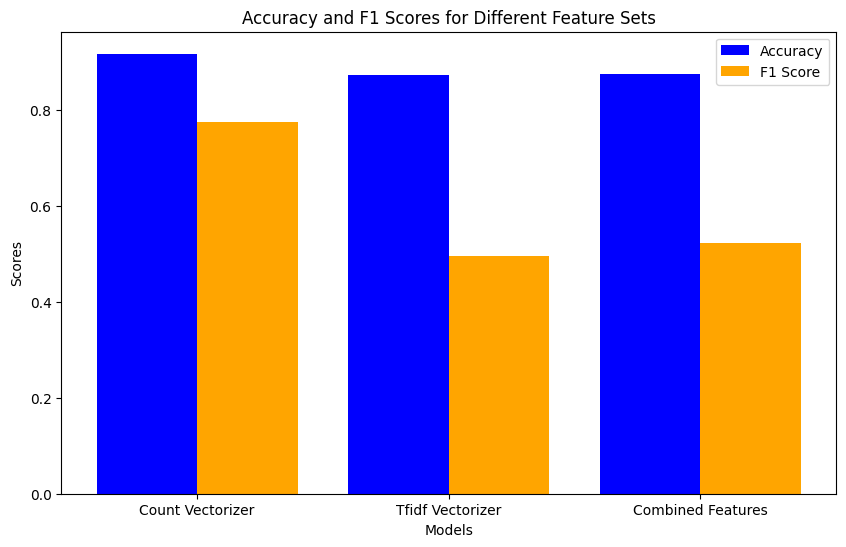

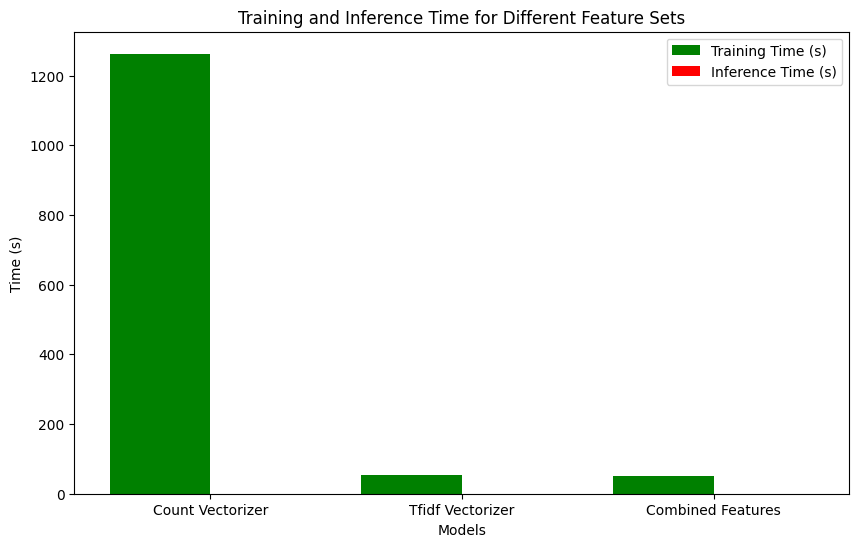

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# 準備數據進行可視化
models = ['Count Vectorizer', 'Tfidf Vectorizer', 'Combined Features']
accuracies = [acc_count, acc_tfidf, acc_combined]
f1_scores = [f1_count, f1_tfidf, f1_combined]
train_times = [train_time_count, train_time_tfidf, train_time_combined]
inference_times = [inference_time_count, inference_time_tfidf, inference_time_combined]

# 繪製準確率與 F1 分數的柱狀圖
plt.figure(figsize=(10,6))
x = np.arange(len(models))

# 準確率
plt.bar(x - 0.2, accuracies, 0.4, label='Accuracy', color='blue')
# F1 分數
plt.bar(x + 0.2, f1_scores, 0.4, label='F1 Score', color='orange')

plt.xticks(x, models)
plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Accuracy and F1 Scores for Different Feature Sets')
plt.legend()

# 顯示結果
plt.show()

# 繪製訓練與推理時間的柱狀圖
plt.figure(figsize=(10,6))

# 訓練時間
plt.bar(x - 0.2, train_times, 0.4, label='Training Time (s)', color='green')
# 推理時間
plt.bar(x + 0.2, inference_times, 0.4, label='Inference Time (s)', color='red')

plt.xticks(x, models)
plt.xlabel('Models')
plt.ylabel('Time (s)')
plt.title('Training and Inference Time for Different Feature Sets')
plt.legend()

# 顯示結果
plt.show()


In [8]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import time

# 初始化分類器
classifiers = {
    "Naive Bayes": MultinomialNB(),
    # "SVM": SVC(),
    "Decision Tree": DecisionTreeClassifier()
}

In [ ]:
# 定義函數來訓練和評估模型
def train_and_evaluate_model(classifier_name, classifier, X_train, y_train, X_test, y_test):
    start_time = time.time()
    # 訓練模型
    classifier.fit(X_train, y_train)
    # 進行預測
    y_pred = classifier.predict(X_test)
    end_time = time.time()
    
    # 計算評估指標
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    # 打印結果
    print(f"Classifier: {classifier_name}")
    print(f"Accuracy: {accuracy}")
    print(f"F1 Score: {f1}")
    print(f"Confusion Matrix:\n{conf_matrix}")
    print(f"Time taken: {end_time - start_time:.2f} seconds\n")
    return accuracy, f1

# 訓練和評估所有分類器
results = {}
for classifier_name, classifier in classifiers.items():
    print(f"Running {classifier_name}...")
    accuracy, f1 = train_and_evaluate_model(
        classifier_name, classifier, X_train_combined, train_data['label'], X_test_combined, test_data['label']
    )
    results[classifier_name] = {"accuracy": accuracy, "f1_score": f1}


Running Naive Bayes...
Classifier: Naive Bayes
Accuracy: 0.8927707742511946
F1 Score: 0.9419792710852792
Confusion Matrix:
[[  9195  43717]
 [   446 358498]]
Time taken: 1.59 seconds

Running Decision Tree...


In [ ]:
import matplotlib.pyplot as plt

# 繪製結果
classifier_names = list(results.keys())
accuracy_scores = [results[name]['accuracy'] for name in classifier_names]
f1_scores = [results[name]['f1_score'] for name in classifier_names]

plt.figure(figsize=(10,5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.bar(classifier_names, accuracy_scores, color='lightblue')
plt.title('Accuracy Scores')
plt.ylim([0, 1])

# F1 Score plot
plt.subplot(1, 2, 2)
plt.bar(classifier_names, f1_scores, color='lightgreen')
plt.title('F1 Scores')
plt.ylim([0, 1])

plt.tight_layout()
plt.show()
